In [82]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate, GridSearchCV

In [5]:
df = pd.read_csv('demo_sales.csv')
df.tail()

,Date,Units,Sales
1088,27/12/2022,7114,22551.38
1089,28/12/2022,7759,24596.03
1090,29/12/2022,6457,20468.69
1091,30/12/2022,7284,23090.28
1092,31/12/2022,0,0.00


### Create features

In [ ]:
target_map = data['sales'].to_dict()

data['lag1'] = (data['date'] - pd.Timedelta('364 days')).map(target_map)
data['lag2'] = (data['date'] - pd.Timedelta('728 days')).map(target_map)
data['lag3'] = (data['date'] - pd.Timedelta('1092 days')).map(target_map)

In [6]:
# Convert dates to datetime format
df['Date'] = pd.to_datetime(df['Date'], 
#               errors='ignore', 
                format='%d/%m/%Y',
                dayfirst=True)
df.tail()

,Date,Units,Sales
1088,2022-12-27,7114,22551.38
1089,2022-12-28,7759,24596.03
1090,2022-12-29,6457,20468.69
1091,2022-12-30,7284,23090.28
1092,2022-12-31,0,0.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1093 non-null   datetime64[ns]
 1   Units   1093 non-null   int64         
 2   Sales   1093 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 25.7 KB


In [8]:
X = df.drop(['Units', 'Sales'], axis=1)
y = df['Units']
X

,Date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
1088,2022-12-27
1089,2022-12-28
1090,2022-12-29
1091,2022-12-30


### Preprocess

In [ ]:

num_features = X

preprocessor = ColumnTransformer(
    [
        ('StandardScaler', StandardScaler(), num_features),
    ]
) 

In [ ]:
X = preprocessor.fit_transform()

### Evaluate models

In [ ]:
def evaluate_model(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

NameError: name 'LinearRegression' is not defined

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'XGBRegressor': XGBRegressor()
}

model_list = []
r2_list = []
rmse_list = []
results = []
param_grid = {'': [0, 1]}


for model_name, model in models.items():
    time_series_split = TimeSeriesSplit(n_splits=6)
    cv_scores = cross_validate(model, X, y, cv=time_series_split)
    #cv_results = cross_val_score(model, X_train, y_train, cv=cv)
    
    # Fine tune hyperparams
    gs = GridSearchCV(model, cv=time_series_split, param_grid=param_grid)
    gs.fit(X, y)
    results.append(cv_scores['test_score'].mean())

    #train_rmse, train_r2 = evaluate_model() # ???
    #y_pred_test = model.predict(X_test)
    #test_rmse, test_r2 = evaluate_model(y_test, y_pred_test)
    print(model_name)
    print('Model performance for Training set')
    print(f'- RMSE: {train_rmse}')
    print(f'- R2: {train_r2}')
    print('-----------------------------')
    print('Model performance for Test set')
    print(f'- RMSE: {test_rmse}')
    print(f'- R2: {test_r2}')

plt.boxplot(results, labels=models.keys())
plt.show()

In [ ]:
# Need to encode date somehow to pass to X

# Create lag features

In [56]:
import numpy as np
import xgboost as xgb
#para = param[LinearRegression()]
# or this, not sure 
param_grid = {'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'n_estimators': [100,200,400]
}
X1 = y.shift(1)
time_series_split = TimeSeriesSplit(test_size=90)


#model = LinearRegression()
model = XGBRegressor(random_state=1)
#xgb.DMatrix()
# Perform randomized grid search on train data and find best params
gs = GridSearchCV(model, param_grid, cv=time_series_split, scoring='neg_root_mean_squared_error')
gs.fit(X1, y)

print("Best CV score: ", np.abs(gs.best_score_))

#model.set_params(**gs.best_params_)
#gs.best_score_

#cv_scores = cross_validate(model, X, y, cv=time_series_split)
#print("CV score: ", cv_scores['test_score'].mean())

Best CV score:  2251.838330078125


In [58]:
gs.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

In [ ]:
# Fit best parameters to model and train it on full data to make real predictions
final_model = XGBRegressor(**gs.best_params)
final_model.fit(X1)
predictions = final_model.predict(*unseen dates*)

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [1]:
import numpy as np
print(np.__version__)

1.26.4


In [2]:
import pmdarima

In [9]:
def check_stationarity(data):
    result = adfuller(data, autolag='AIC')
    p_value = result[1]
    print(f'p-value is {round(p_value, 3)}' + ' => ' + 'Stationary' if p_value < 0.05 else 'Non-stationary')

check_stationarity(y)

p-value is 0.0 => Stationary


Time-series is stationary, therefore we **can** apply SARIMA

In [76]:
X_train = df[['Date','Units']][:-90].set_index('Date')
X_test = df[['Date','Units']][-90:].set_index('Date')
y_train = y[:-90]
y_test = y[-90:]
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12
model = SARIMAX(X_train, order=(p,d,q), seasonal_order=(P,D,Q,s))
trained_model = model.fit()

forecast = trained_model.get_forecast(steps=90)


c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is a

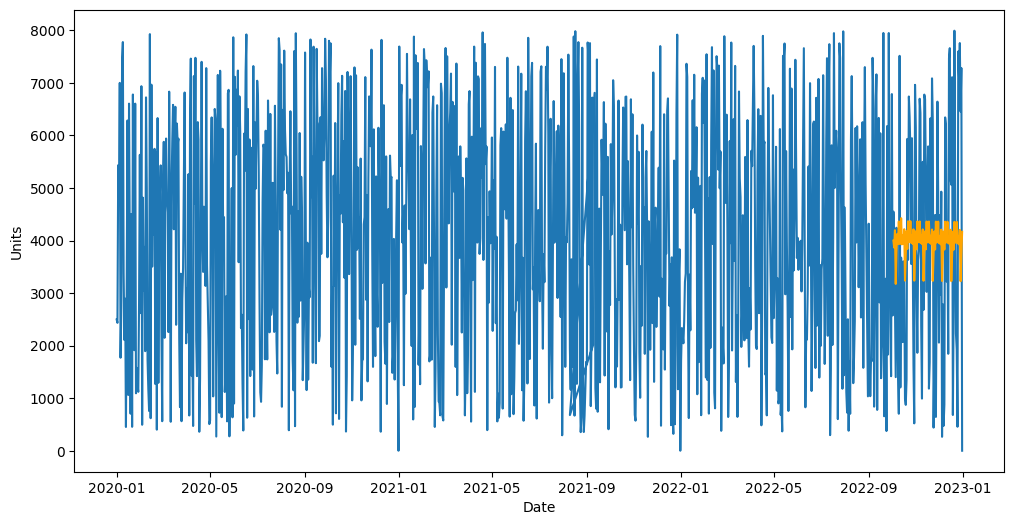

In [82]:
import matplotlib.pyplot as plt
all_data = df[['Date','Units']].set_index('Date')
plt.figure(figsize=(12,6))
plt.plot(all_data, label='Observed')
plt.plot(X_test.index, forecast.predicted_mean, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Units')
plt.show()

The model is quite bad, need to fine-tune it

In [ ]:
param_grid = {'p': [0,1],
              'd': [0,1],
              'q': [0,1],
              'P': [0,1],
              'D': [0,1],
              'Q': [0,1],
              's': [12]
              }

time_series_split = TimeSeriesSplit(test_size=90)
# idk how to perform gridsearch on sarima model, the model wants data as mandatory input and it contradicts the GS func params
model = SARIMAX(time_series_split)
gs = GridSearchCV(model, param_grid, cv=time_series_split, scoring='neg_root_mean_squared_error')
gs.fit(X_train.index, X_train)

TypeError: object of type 'TimeSeriesSplit' has no len()

In [ ]:
final_model = SARIMAX(**gs.best_params)
final_model.fit()
forecast1 = final_model.get_forecast(steps=90)

1003    3998.449101
1004    3866.399832
1005    4196.835878
1006    3174.777798
1007    3791.256789
           ...     
1088    3925.895877
1089    4203.734368
1090    3226.262258
1091    3719.454801
1092    4166.152706
Name: predicted_mean, Length: 90, dtype: float64

In [10]:
from pmdarima import auto_arima

train = df[['Date','Units']][:-90].set_index('Date')
test = df[['Date','Units']][-90:].set_index('Date')
#y_train = y[:-90]
#y_test = y[-90:]
sarima = auto_arima(train, seasonal=True, m=7)
predictions = sarima.predict(n_periods=len(test))
rmse = root_mean_squared_error(test, predictions)
print('RMSE: ', rmse)

c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecast

RMSE:  2307.8549952192357


c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


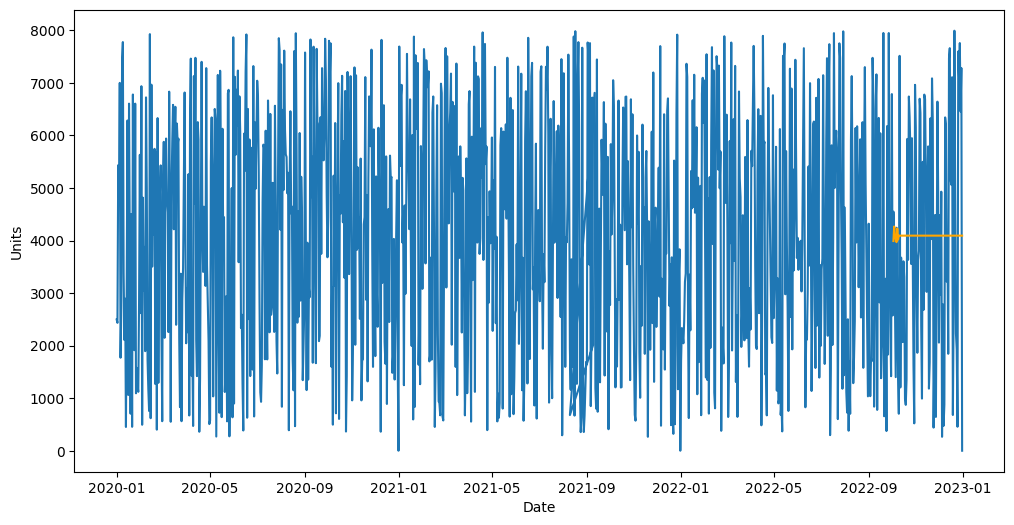

In [22]:
import matplotlib.pyplot as plt

def plot_predictions(test, predictions):
    all_data = df[['Date','Units']].set_index('Date')
    plt.figure(figsize=(12,6))
    plt.plot(all_data, label='Observed')
    plt.plot(test.index, predictions, label='Forecast', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Units')
    plt.show()

plot_predictions(test, predictions)

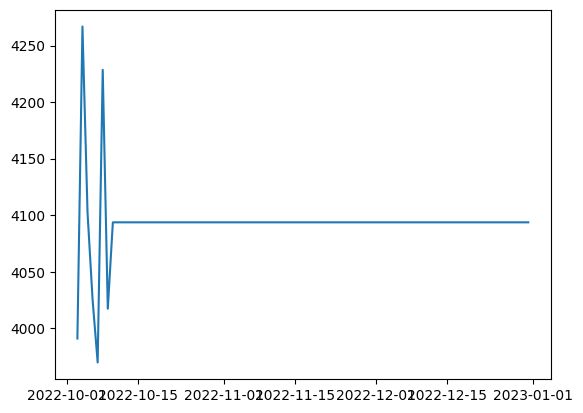

In [15]:
plt.plot(test.index, predictions)

In [20]:
from sklearn.model_selection import cross_val_score, ParameterGrid

rmse = []
grid = {'p': [0,1],
        'd': [0,1],
        'q': [0,1],
        'P': [0,1],
        'D': [0,1],
        'Q': [0,1],
        }
param_grid = ParameterGrid(grid)

for params in param_grid:
    # Model
    model = pmdarima.ARIMA(order = (params['p'],params['d'],params['q']),
                           seasonal_order = (params['P'],params['D'],params['Q'], 7),
                           suppress_warnings = True,
                           force_stationarity = False
                           )
    # CV
    cv_split = TimeSeriesSplit(test_size=90)
    cv_score = cross_val_score(model,
                               X = train.index,
                               y = train,
                               scoring = 'neg_mean_squared_error',
                               cv = cv_split
                               )
    # Error
    error = np.sqrt(np.average(cv_score))
    rmse.append(error)



c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-package

KeyboardInterrupt: 

In [ ]:
tuning_results = pd.DataFrame(param_grid)
tuning_results['rmse'] = rmse
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
print(best_params)

In [36]:
# Fine-tuning SARIMA with auto_arima
sarima = auto_arima(train, 
                    start_p = 0,
                    d = 0,
                    start_q = 0,
                    max_p = 500,
                    max_q = 500,
                    start_P = 0,
                    D = 0,
                    start_Q = 0,
                    max_P = 1, 
                    max_Q = 1,
                    seasonal = True, 
                    m = 7,
                    random_state = 1,
                    suppress_warnings = True)
predictions = sarima.predict(n_periods=len(test))
rmse = root_mean_squared_error(test, predictions)
print('RMSE: ', rmse)

c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecast

RMSE:  2307.8549952192357


c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


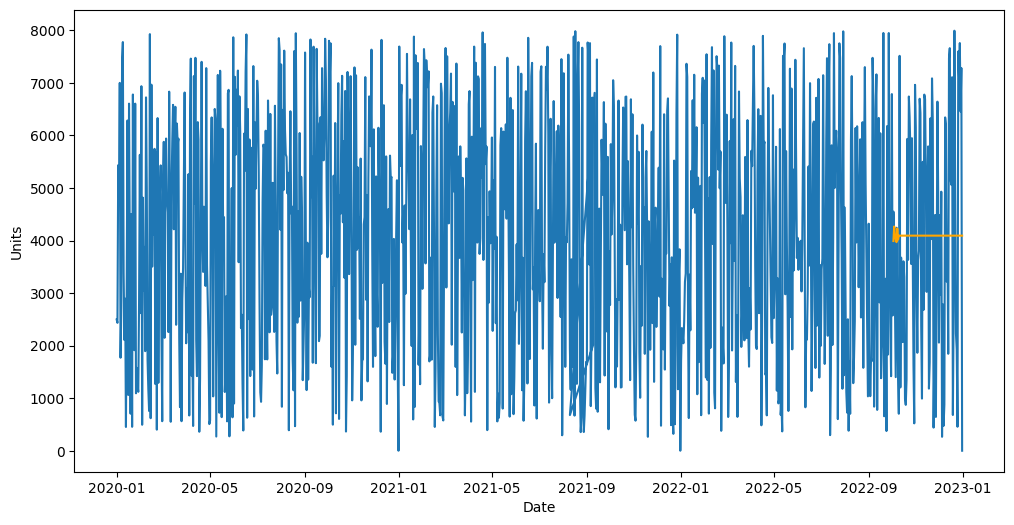

In [37]:
plot_predictions(test, predictions)

In [ ]:
sarima.summary()

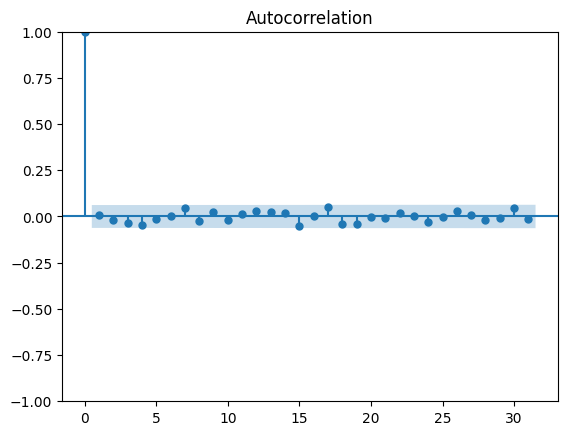

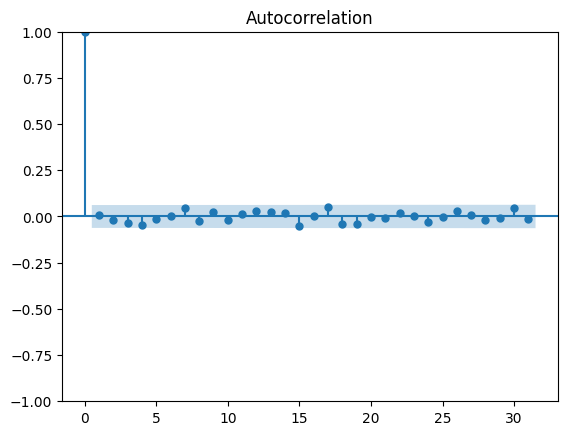

In [30]:
import statsmodels.api as st
st.graphics.tsa.plot_acf(train)

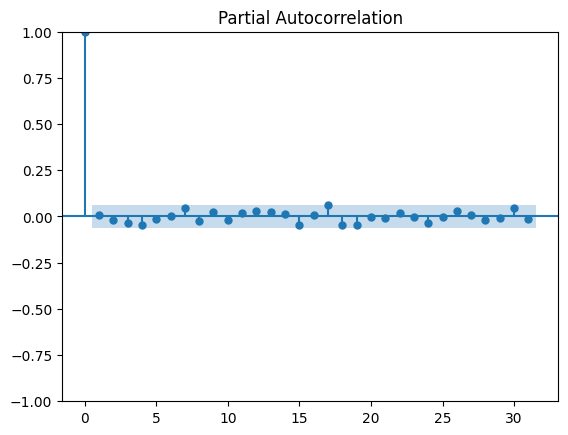

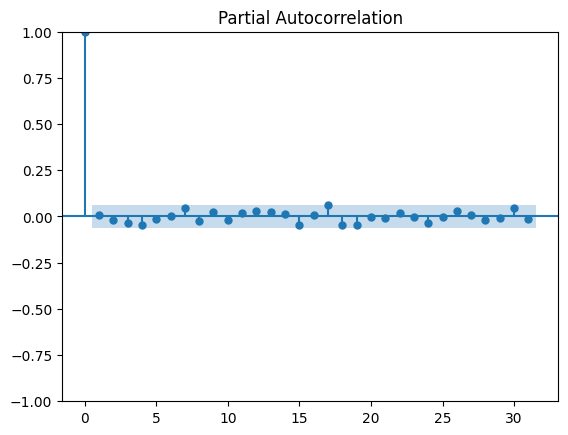

In [31]:
st.graphics.tsa.plot_pacf(train)

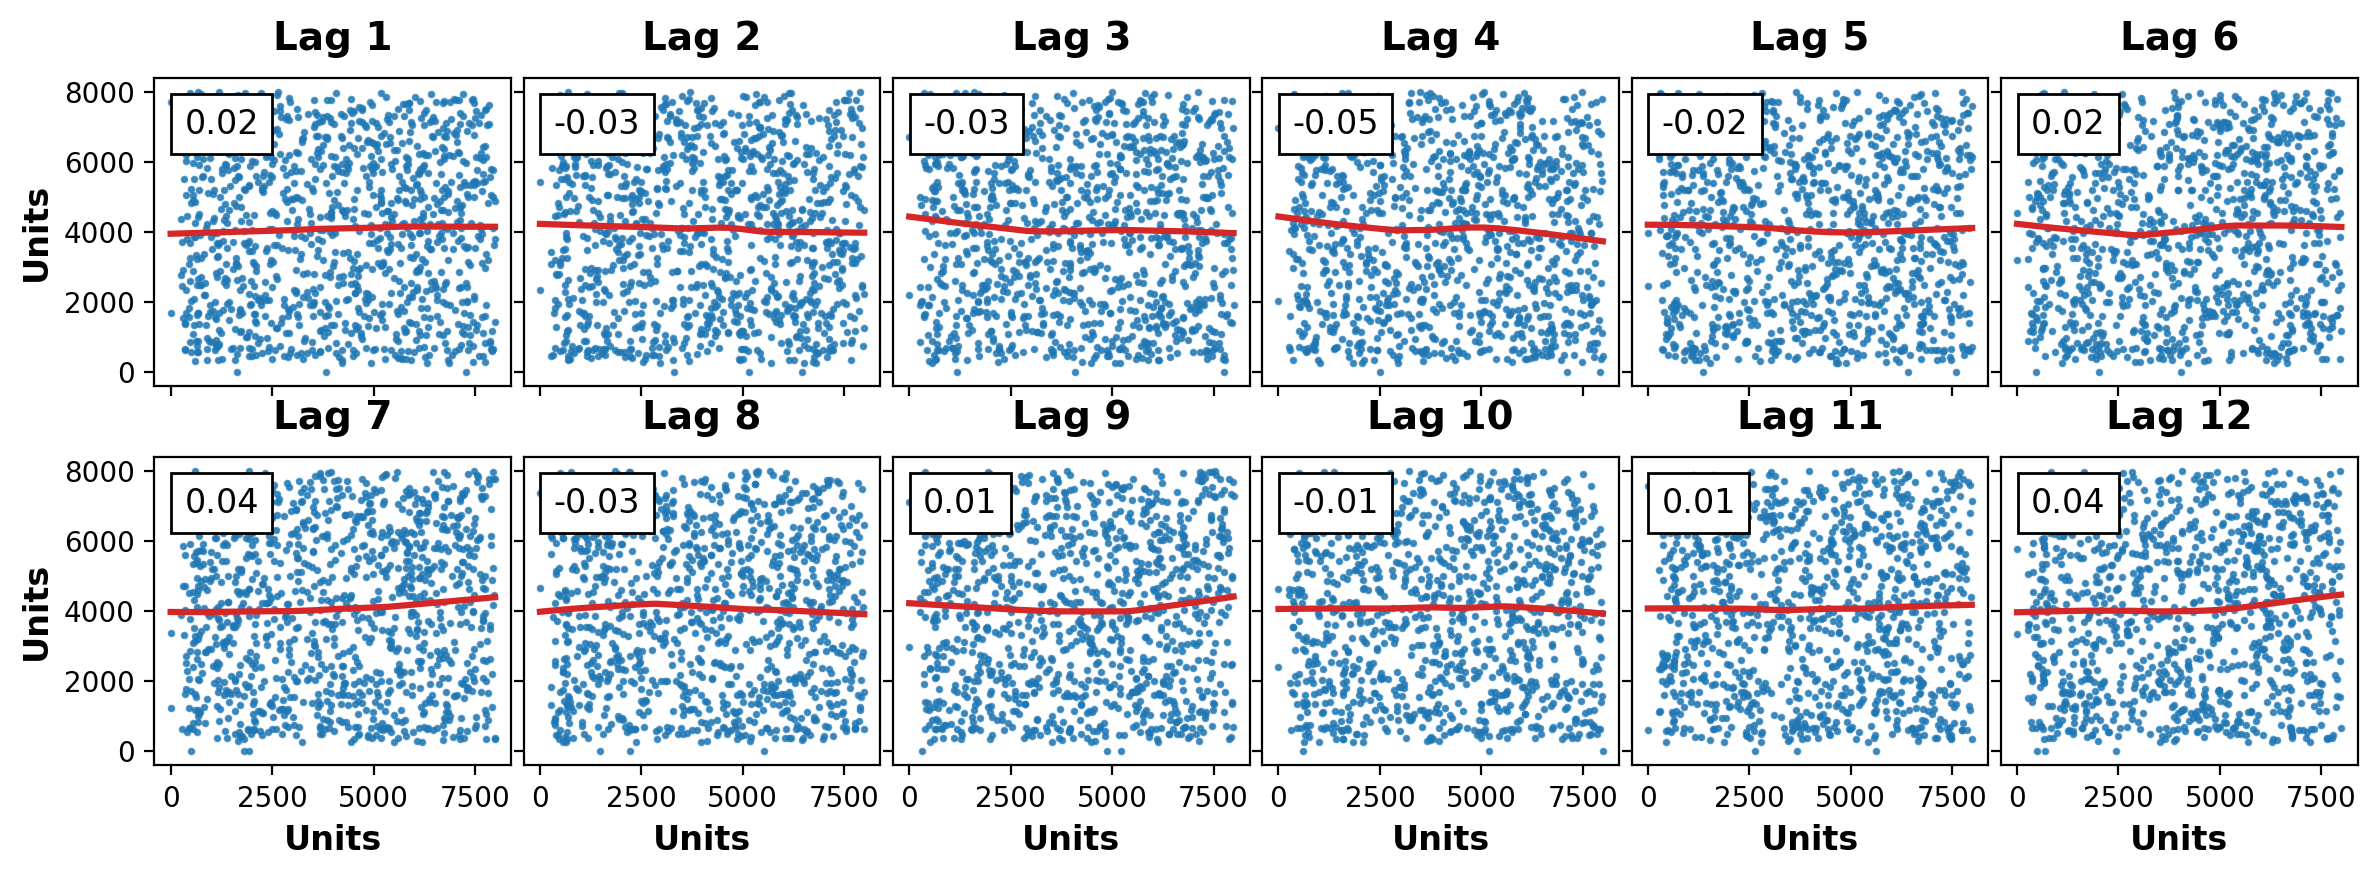

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
                alpha=0.75,
                s=3,)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

_ = plot_lags(all_data['Units'], lags=12, nrows=2)

In [38]:
# Data doesn't have autocorrelations. => What then?
# Gotta try to fine-tune values for SARIMA from auto_arima. 
# Try to find diff data

In [ ]:
# Testing dict with tuple output
report = {
          '1': ('model1', 353),
          '2': ('model2', 796),
          '3': ('model3', 80),
          '4': ('model4', 801),
          '5': ('model5', 55),
}
# Get best model and best score
best_model = max(report.items(), key=lambda v: v[1][1])[0]
best_model_score = max(report.items(), key=lambda v: v[1][1])[1][1]
print('best_model: ', best_model)
print('best_model_score: ', best_model_score)

best_model:  4
best_model_score:  801


### Trying XGBoost

In [144]:
from scipy.fft import fft

all_data = pd.read_csv('demo_sales.csv')
all_data['Date'] = pd.to_datetime(all_data['Date'], 
                format='%d/%m/%Y',
                dayfirst=True)

y = all_data['Units']
X = pd.DataFrame()
X['lag'] = y.shift(1)
X['lag2'] = y.shift(2)
X['lag3'] = y.shift(3)
X['lag7'] = y.shift(7)
X['lag30'] = y.shift(30)
X['time'] = np.arange(len(y))
X['rolling_mean'] = y.rolling(window=5).mean()
X['fourier_transform'] = np.abs(fft(y))
X['day_of_month'] = all_data['Date'].dt.day
X['month'] = all_data['Date'].dt.month
X['day_of_year'] = all_data['Date'].dt.dayofyear
X['day_of_week'] = all_data['Date'].dt.dayofweek

In [115]:
param_grid = {'learning_rate': [0.01, 0.1, 0.2],
              'n_estimators': [100, 300],
              'sub_sample': [0, 0.4, 0.8]
}

model = XGBRegressor()
ts_split = TimeSeriesSplit(n_splits=8, test_size=90)
gs = GridSearchCV(model, param_grid, cv=ts_split, scoring='neg_root_mean_squared_error')
gs.fit(X, y)
model.set_params(**gs.best_params_)
model_score = np.abs(gs.best_score_)

c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sub_samp

In [ ]:
print(gs.best_params_, '\n', model_score)

{'learning_rate': 0.01, 'n_estimators': 300, 'sub_sample': 0} 
 1917.2745208740234


In [128]:
import warnings
warnings.filterwarnings('ignore')

X = pd.DataFrame()
X['time'] = np.arange(len(y))
X['day_of_month'] = all_data['Date'].dt.day
X['month'] = all_data['Date'].dt.month
X['day_of_year'] = all_data['Date'].dt.dayofyear
X['day_of_week'] = all_data['Date'].dt.dayofweek

model2 = XGBRegressor(random_state=1)
gs2 = GridSearchCV(model2, param_grid, cv=ts_split, scoring='neg_root_mean_squared_error')
gs2.fit(X, y)
model2.set_params(**gs2.best_params_)
model_score2 = np.abs(gs2.best_score_)
print(gs2.best_params_, '\n', model_score2)

{'learning_rate': 0.01, 'n_estimators': 100, 'sub_sample': 0} 
 2357.0994567871094


In [141]:
model2.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [142]:
X_future = pd.DataFrame()
X_future['Date'] = pd.date_range('2023-01-01', periods=90)
X_future['time'] = np.arange(1093, 1093+90)
X_future['day_of_month'] = X_future['Date'].dt.day
X_future['month'] = X_future['Date'].dt.month
X_future['day_of_year'] = X_future['Date'].dt.dayofyear
X_future['day_of_week'] = X_future['Date'].dt.dayofweek

model2.predict(X_future.drop('Date',axis=1))

array([4869.7886, 5148.517 , 5176.744 , 5074.0522, 4969.195 , 4929.736 ,
       4929.736 , 4726.214 , 5142.1304, 5326.3184, 5213.4707, 5132.636 ,
       5080.791 , 5080.791 , 4914.108 , 5168.8135, 5388.2485, 5272.5728,
       5191.7383, 5161.1865, 5161.1865, 5059.1733, 4858.631 , 5042.819 ,
       5042.819 , 4984.0493, 5174.3975, 4937.518 , 5011.304 , 4828.7144,
       3394.705 , 5247.4897, 5269.4683, 4929.736 , 4929.736 , 4726.214 ,
       5010.0327, 5194.2207, 5091.529 , 5347.5093, 5163.738 , 5080.791 ,
       4877.269 , 5137.065 , 5321.253 , 5255.4   , 5301.4014, 5152.877 ,
       5272.38  , 5272.38  , 5153.3438, 5383.9062, 4736.244 , 4736.244 ,
       5092.58  , 5092.58  , 5184.4097, 5057.573 , 5073.7153, 5292.1606,
       5197.902 , 5041.941 , 5041.941 , 5041.941 , 5238.8916, 5238.8916,
       5136.1997, 5275.943 , 5275.943 , 5192.996 , 5192.996 , 5365.924 ,
       5365.924 , 5300.071 , 5229.835 , 5265.082 , 5252.098 , 5211.17  ,
       5384.0977, 5384.0977, 5092.58  , 5092.58  , 

##### Model is still shit. (predictions are around ~5000, while in reailty values are up to 20k)

In [ ]:
model.fit(X,y)
importances = model.feature_importances_
feature_names = model.feature_names_in_

<BarContainer object of 12 artists>

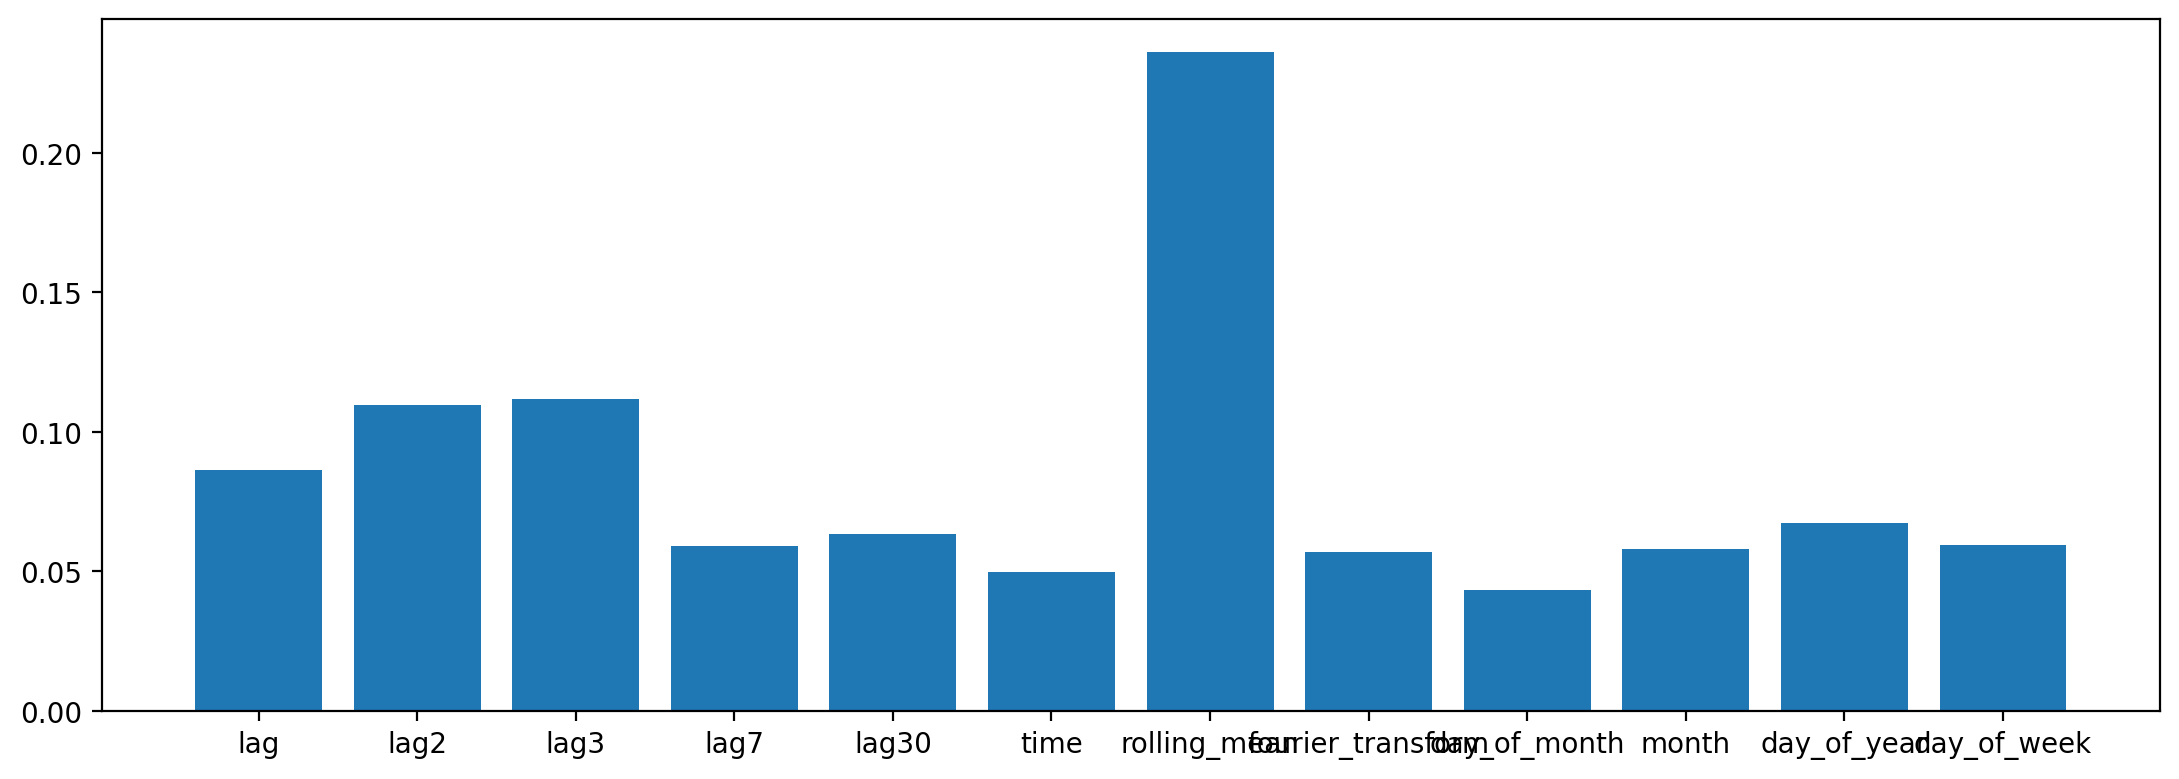

In [156]:
plt.bar(x=feature_names, height=importances)

<BarContainer object of 5 artists>

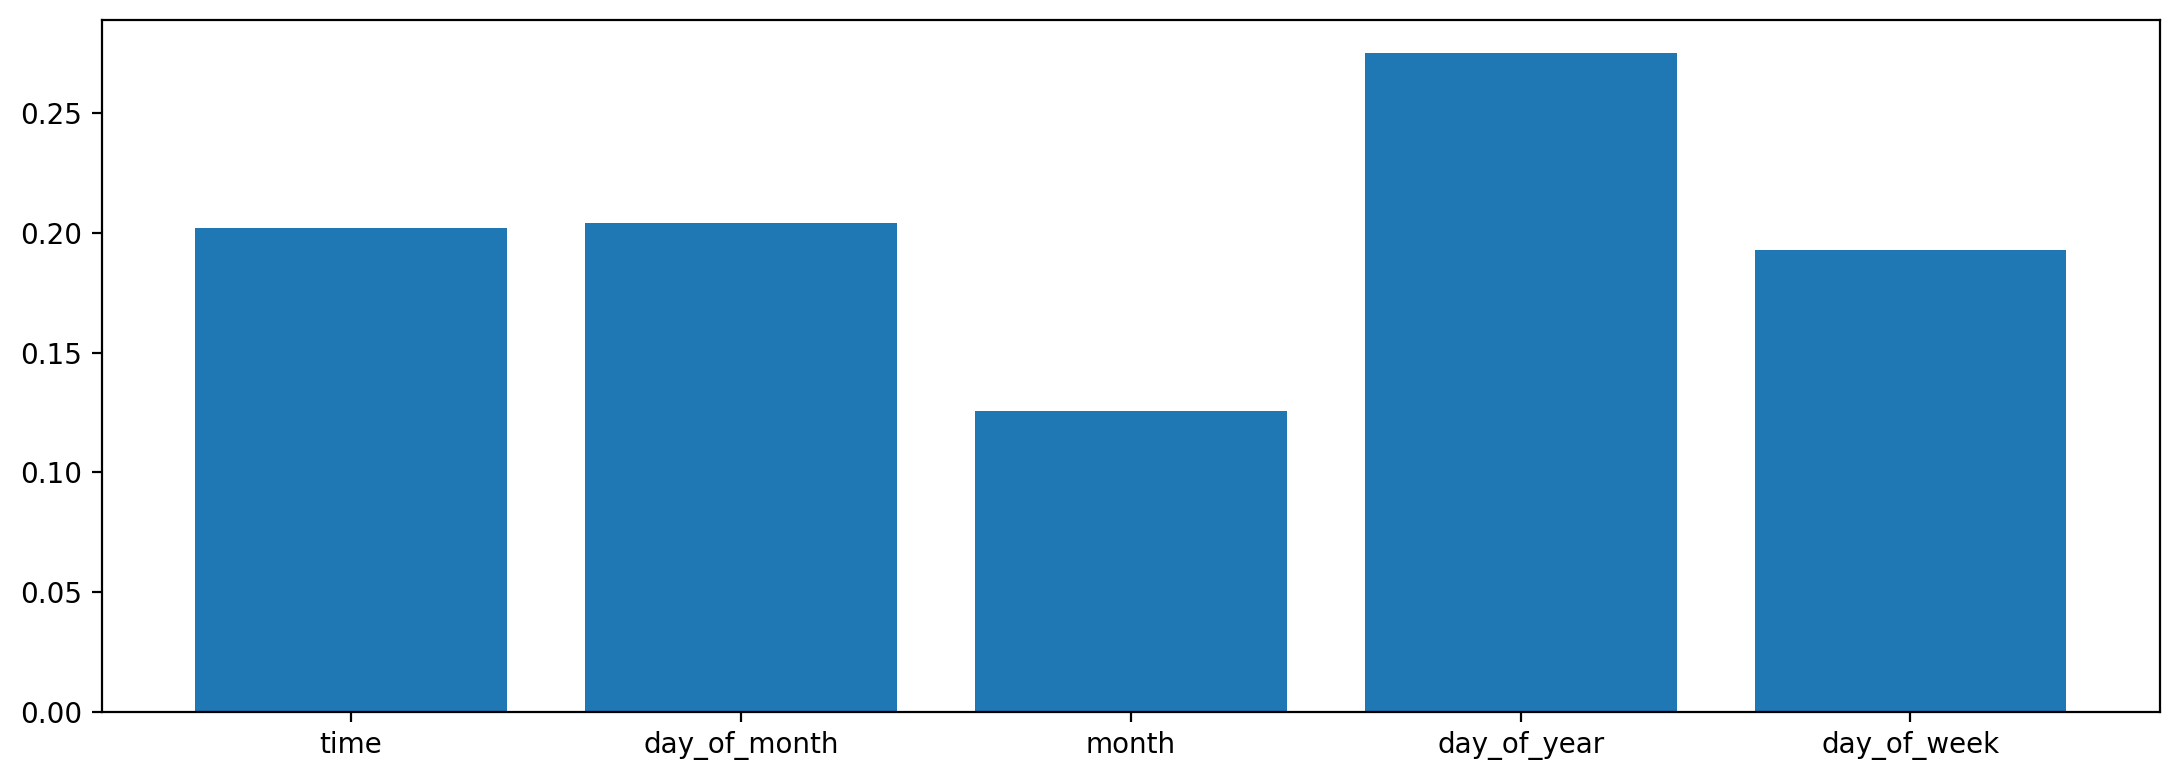

In [157]:
plt.bar(x=model2.feature_names_in_, height=model2.feature_importances_)